# Biol 359A | Statistical Tests: ANOVA
### Spring 2024, Week 3
Objectives:
- TODO: Write summaries of objectives here

In [1]:
# Import necessary libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
import ipywidgets as widgets
import pandas as pd

---

### Sample Size, Effect Size, and Power

Use the sliders in the vizualization below to explore the relationship. The code below will use the value specified by the "effect size" slider to generate data from two normal distributions with means `effect_size` apart. It then takes samples of the size specified by the "sample size" slider from each and performs a t-test. It repeats this sampling and t-test 200 times and then displays a histogram of the resulting p-values. The power of the test is displayed below the histogram.

In [23]:

def simulate_t_test(sample_size, effect_size):
    # Generate fake data
    group1 = np.random.normal(0, 1, 10000)  # Control group with mean=0 and std=1
    group2 = np.random.normal(effect_size, 1, 10000)  # Experimental group with mean=effect_size and std=1
    
    p_values = []
    for _ in range(200):
        sample1 = np.random.choice(group1, sample_size)
        sample2 = np.random.choice(group2, sample_size)
        _, p_value = stats.ttest_ind(sample1, sample2)
        p_values.append(p_value)
    
    # Calculate power
    alpha = 0.05
    power = np.mean(np.array(p_values) < alpha)
    
    # Plot histogram of p-values
    plt.hist(p_values, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.title('Histogram of p-values')
    plt.xlim(0, 1)  # Ensure x-axis does not go negative and is capped at 1
    plt.show()
    
    print(f"Power of the test (alpha = .05): {power:.3f}")

# Create interactive widgets
_ = interact(simulate_t_test,
         sample_size=IntSlider(min=10, max=1000, step=10, value=100, description='Sample Size'),
         effect_size=FloatSlider(min=0, max=1, step=0.1, value=0, description='Effect Size'))

interactive(children=(IntSlider(value=100, description='Sample Size', max=1000, min=10, step=10), FloatSlider(…

ASSIGNMENT QUESTIONS:
- Please answer questions 11 and 12 in the assignment.

DISCUSSION QUESTIONS:
- Despite using a constant effect size in each simulation, the p-values vary widely across the 200 repetitions. Why is this? How does the effect size impact the distribution of p values? Why? 

---

### Repeated statistical tests and type 1 error

We have discussed several times how repeating statistical tests on the same data inflates type 1 error. The code below illustrates this point.

The code below generates fake gene expression data for 100 cells. Each cell has expression data for 100 genes. All gene expression data is pulled from the same uniform distribution. A random half of the cells are labeled "healthy" and the other half labeled "sick.

The code then performs a t-test comparing the mean expression of the healthy cells to the mean expression of the sick cells for all 40 genes (40 different t-tests). 

The plot on the left shows the distribution of all p-values for all 100 t-tests. The plot on the right shows the Cumulative Distribution Function (CDF) plot. Each point on the plot represents a p-value. The point's x value is the p-value and the point's y value is the percent of p-values in the set of all 100 that are equal to or less than that p-value. Under the null hypothesis (assuming no real difference between the healthy and sick cells' gene expression levels), we expect the p-values to follow a uniform distribution. This means that each p-value is equally likely, ranging from 0 to 1. On the CDF plot, a uniform distribution is represented by a diagonal line that runs from the bottom left to the top right of the graph. Deviations from this line might indicate departures from the expected distribution under the null hypothesis.

The number of significantly different genes found is reported below the plots along with the gene IDs and their respective p-values.

**The code below is non-deterministic**. This means that each time you run the code, the process will run with a new set of data and you will get different results. Run the cell a bunch of times to see a range of possible outcomes!

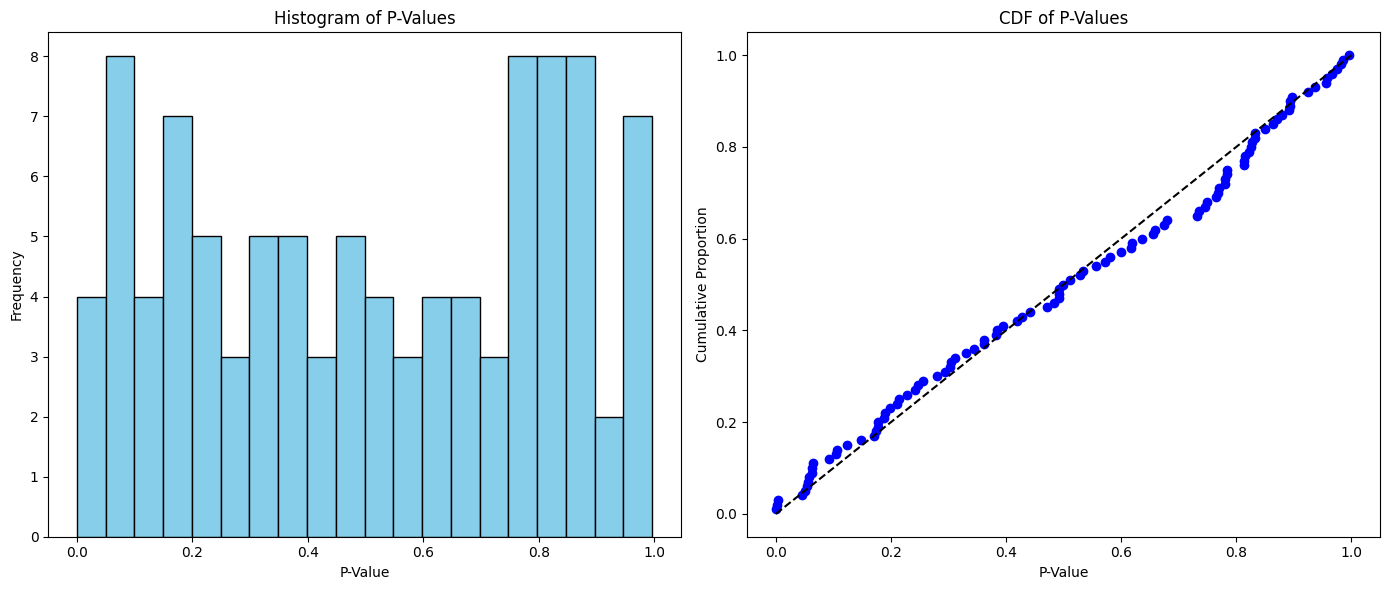

Total tests conducted: 100
Significant tests (P < 0.05): 4

Significant tests details:
       Gene   P-Value
6    Gene 7  0.045831
9   Gene 10  0.000002
53  Gene 54  0.003479
54  Gene 55  0.002157


In [14]:
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt

# Generate random gene expression data
num_cells = 100  # Total number of cells, half healthy, half sick
num_genes = 100  # Number of genes per cell
gene_expression = np.random.rand(num_cells, num_genes) # uniform distribution [0, 1)
labels = np.array(["healthy"] * (num_cells // 2) + ["sick"] * (num_cells // 2))

# Perform t-tests and collect p-values
results = {"Gene": [], "P-Value": []}
for gene_idx in range(num_genes):
    healthy_expression = gene_expression[labels == "healthy", gene_idx]
    sick_expression = gene_expression[labels == "sick", gene_idx]
    _, p_value = ttest_ind(healthy_expression, sick_expression)
    results["Gene"].append(f"Gene {gene_idx + 1}")
    results["P-Value"].append(p_value)

# Set significance threshold
alpha = .05

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)
significant_results = results_df[results_df["P-Value"] < alpha]

# Plot histogram of p-values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(results_df["P-Value"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Histogram of P-Values')

# Plot CDF of p-values
plt.subplot(1, 2, 2)
sorted_p_values = np.sort(results_df["P-Value"])
plt.plot(sorted_p_values, np.arange(1, len(sorted_p_values)+1) / len(sorted_p_values), marker='o', linestyle='none', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Line of perfect uniformity
plt.xlabel('P-Value')
plt.ylabel('Cumulative Proportion')
plt.title('CDF of P-Values')

plt.tight_layout()
plt.show()

# Display results summary
print(f"Total tests conducted: {num_genes}")
print(f"Significant tests (P < 0.05): {len(significant_results)}")
print("\nSignificant tests details:")
print(significant_results)


DISCUSSION QUESTIONS:
- How many genes would we expect to be significantly different between the two populations? How does this compare to the number of genes you see are significantly different?
- How does the distribution of p-values compare to the distribution of p-values we would expect under the null hypothesis?
- Why do we expect the p-values to be uniformly distributed under the null hypothesis?

#### Bonferroni Correction
The code below repeats the process, but uses the Bonferroni correction. Remember, this means we divide $\alpha$ by the number of hypotheses being tested (in this case 100). Run this cell a bunch of times to see a range of possible outcomes.

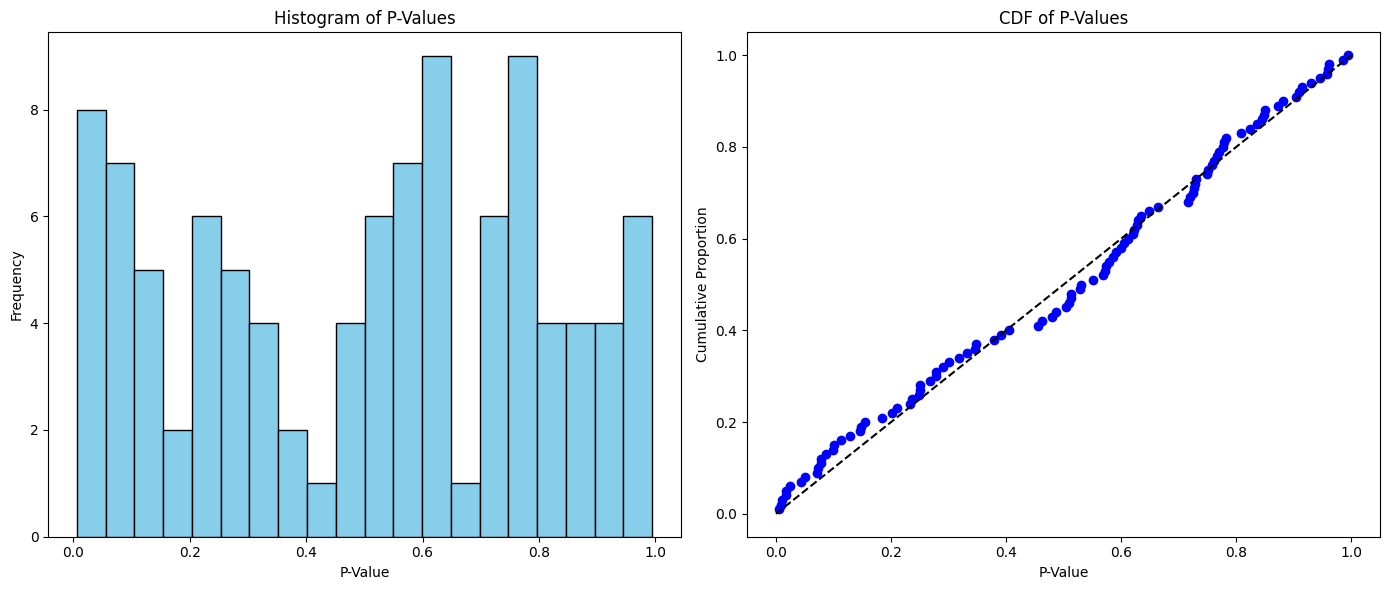

Total tests conducted: 100
Significant tests (P < 0.0005): 0

Significant tests details:
Empty DataFrame
Columns: [Gene, P-Value]
Index: []


In [18]:
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt

# Generate random gene expression data
num_cells = 100  # Total number of cells, half healthy, half sick
num_genes = 100  # Number of genes per cell
gene_expression = np.random.rand(num_cells, num_genes) # uniform distribution [0, 1)
labels = np.array(["healthy"] * (num_cells // 2) + ["sick"] * (num_cells // 2))

# Perform t-tests and collect p-values
results = {"Gene": [], "P-Value": []}
for gene_idx in range(num_genes):
    healthy_expression = gene_expression[labels == "healthy", gene_idx]
    sick_expression = gene_expression[labels == "sick", gene_idx]
    _, p_value = ttest_ind(healthy_expression, sick_expression)
    results["Gene"].append(f"Gene {gene_idx + 1}")
    results["P-Value"].append(p_value)

# Set significance threshold
alpha = .05
# Bonferroni correction
corrected_alpha = alpha / num_genes

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)
significant_results = results_df[results_df["P-Value"] < corrected_alpha]

# Plot histogram of p-values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(results_df["P-Value"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Histogram of P-Values')

# Plot CDF of p-values
plt.subplot(1, 2, 2)
sorted_p_values = np.sort(results_df["P-Value"])
plt.plot(sorted_p_values, np.arange(1, len(sorted_p_values)+1) / len(sorted_p_values), marker='o', linestyle='none', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Line of perfect uniformity
plt.xlabel('P-Value')
plt.ylabel('Cumulative Proportion')
plt.title('CDF of P-Values')

plt.tight_layout()
plt.show()

# Display results summary
print(f"Total tests conducted: {num_genes}")
print(f"Significant tests (P < {corrected_alpha}): {len(significant_results)}")
print("\nSignificant tests details:")
print(significant_results)


DISCUSSION QUESTIONS:
- How does the output of these tests compare to the outcomes of the uncorrected tests?

The Bonferroni correction is a powerful tool, but it comes at the cost of statistical power. The visualization below allows you to generate two datasets drawn from normal distributions with means `effect size` apart. It then repeats 100 t-tests on the same data. Explore how effect size and sample size affect statistical power before and after conducting a Bonferroni correction in a case where many statistical tests are performed on the same data.

In [25]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

def simulate_t_test(sample_size, effect_size):
    # Parameters
    num_tests = 100  # Number of t-tests
    alpha = 0.05  # Significance level without correction
    corrected_alpha = alpha / num_tests  # Bonferroni corrected alpha
    
    # Generate fake data
    group1 = np.random.normal(0, 1, 10000)  # Control group with mean=0 and std=1
    group2 = np.random.normal(effect_size, 1, 10000)  # Experimental group with mean=effect_size and std=1
    
    p_values = []
    for _ in range(num_tests):
        sample1 = np.random.choice(group1, sample_size)
        sample2 = np.random.choice(group2, sample_size)
        _, p_value = stats.ttest_ind(sample1, sample2)
        p_values.append(p_value)
    
    # Calculate power
    power_before = np.mean(np.array(p_values) < alpha)
    power_after = np.mean(np.array(p_values) < corrected_alpha)
    
    # Plot histogram of p-values
    plt.hist(p_values, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.title('Histogram of P-values')
    plt.xlim(0, 1)  # Ensure x-axis does not go negative and is capped at 1
    plt.axvline(x=alpha, color='red', linestyle='--', label='Alpha (0.05)')
    plt.axvline(x=corrected_alpha, color='green', linestyle='--', label=f'Corrected Alpha ({corrected_alpha:.4f})')
    plt.legend()
    plt.show()
    
    # Print power of the test
    print(f"Power of the test before correction (alpha = .05): {power_before:.3f}")
    print(f"Power of the test after correction: {power_after:.3f}")

# Create interactive widgets
_ = interact(simulate_t_test,
         sample_size=IntSlider(min=10, max=1000, step=10, value=100, description='Sample Size'),
         effect_size=FloatSlider(min=0, max=1, step=0.1, value=0.1, description='Effect Size'))


interactive(children=(IntSlider(value=100, description='Sample Size', max=1000, min=10, step=10), FloatSlider(…

DISCUSSION QUESTIONS:
- How does sample size affect statistical power?
- How do the statistical powers compare before and after the Bonferroni correction?

---

### The F Distribution

As we discussed in class, the test statistic in an ANOVA is the F statistic. Under the null hypothesis, the F statistic follows an F distribution. The shape of an F distribution varys depending on the number of data points you have and the number of groups you are comparing. Use the visualization below to explore how changes in the different degrees of freedom affect the shape of the distribution.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from ipywidgets import interact, IntSlider, Layout

def plot_f_distribution(df1, df2):
    # Define the range of x values
    x = np.linspace(0.01, 5, 1000)
    
    # Calculate the F-distribution
    y = f.pdf(x, df1, df2)
    
    # Plot the F-distribution
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, color='skyblue')
    plt.fill_between(x, y, color='skyblue', alpha=0.5)
    
    plt.title('F-distribution')
    plt.xlabel('F value')
    plt.ylabel('Probability density')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

# Custom layout to ensure slider descriptions are not cut off
custom_layout = Layout(width='800px', description_width='initial')

# Create interactive widgets with custom layout
interact(plot_f_distribution,
         df1=IntSlider(min=1, max=30, step=1, value=5, description='Numerator Degrees of Freedom (DF1: Number of groups - 1)', style={'description_width': 'initial'}, layout=custom_layout),
         df2=IntSlider(min=1, max=100, step=1, value=20, description='Denominator Degrees of Freedom (DF2: Number of data points - Number of groups)', style={'description_width': 'initial'}, layout=custom_layout))


interactive(children=(IntSlider(value=5, description='Numerator Degrees of Freedom (DF1: Number of groups - 1)…

<function __main__.plot_f_distribution(df1, df2)>

ASSIGNMENT QUESTIONS:
- Please complete assignment questions 13, 14 and 15

---

#### One-way ANOVA

One-way ANOVA (Analysis of Variance) is a statistical test used when we want to compare the means of more than two groups based on one independent variable. One-way ANOVA can help us understand if at least one group mean is different, but does not tell us which specific groups differ.

When to Use One-Way ANOVA:
- Multiple Groups Comparison: Use one-way ANOVA when you have three or more groups for comparison. For example, comparing the effectiveness of different teaching methods on student performance.
- One Independent Variable: There should be one categorical independent variable with two or more levels (e.g., treatment types).
- One Dependent Variable: The dependent variable should be continuous (e.g., test scores).
- Independence of Observations: Each group's observations should be independent of the others.
- Normality and Homogeneity of Variance: The data should approximately follow a normal distribution, and the variance among groups should be similar, though one-way ANOVA is fairly robust to deviations from these assumptions.

The following interactive visualization allows you to adjust the number of groups, the variance within those groups, and the mean difference between the groups. The code then generates 50 data points for each group and conducts a one-way ANOVA.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import ipywidgets as widgets
from ipywidgets import interact

def plot_one_way_anova(num_groups=3, within_group_var=1, mean_diff=0):
    np.random.seed(0)  # For reproducibility
    group_means = np.linspace(0, mean_diff, num=num_groups)
    data = [np.random.normal(loc=mean, scale=np.sqrt(within_group_var), size=50) for mean in group_means]
    
    # ANOVA
    f_stat, p_value = f_oneway(*data)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for i, group in enumerate(data):
        plt.scatter([i+1]*len(group), group, alpha=0.7, label=f'Group {i+1}')
    plt.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f'One-Way ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.3f}')
    plt.xlabel('Group')
    plt.ylabel('Values')
    plt.xticks(range(1, num_groups + 1))
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Adjusting widget layout
style = {'description_width': 'initial'}
# Custom layout to ensure slider descriptions are not cut off
custom_layout = Layout(width='400px', description_width='initial')
_ =interact(plot_one_way_anova,
         num_groups=widgets.IntSlider(min=2, max=5, step=1, value=3, description='Number of Groups', style=style, layout=custom_layout),
         within_group_var=widgets.FloatSlider(min=0.5, max=5, step=0.5, value=1, description='Within Group Variance', style=style, layout=custom_layout),
         mean_diff=widgets.FloatSlider(min=0, max=5, step=0.5, value=0, description='Mean Difference Between Groups', style=style, layout=custom_layout))


interactive(children=(IntSlider(value=3, description='Number of Groups', layout=Layout(width='400px'), max=5, …

DISCUSSION QUESTIONS:
- We discussed in class how the F statistic is the ratio of the between group variance divided by the numerator degrees of freedom to the within group variance divided by the denominator degrees of freedom. In this way, the F statistic compares the between group variance to the within group variance. Does the between group variance need to be larger than the within group variance to get a significant P-value?

ASSIGNMENT QUESTIONS:
- Please complete question 16 in the assignment.

#### Two-way ANOVA
Two-way ANOVA (Analysis of Variance) extends the principles of one-way ANOVA to examine the effects of two independent variables (factors) on a dependent variable simultaneously. This method not only assesses the main effect of each factor but also investigates whether there is an interaction between them. This interaction effect is crucial, as it indicates whether the effect of one factor depends on the level of the other factor.

When to Use Two-Way ANOVA:
- Multiple Factors: Use two-way ANOVA when your study involves two independent variables and you are interested in understanding both their individual (main effects) and combined (interaction effect) impacts on a dependent variable.
- Interaction Effects: Two-way ANOVA is particularly valuable when you suspect that the impact of one independent variable on the dependent variable might change across levels of the other independent variable.
 - Example Contexts: Comparing student performance across different teaching methods (Factor 1) and class sizes (Factor 2) to see not only which method and size are best but also if some methods work better or worse in different sizes.

This is a bit abstract, so lets ground it in an example.

Imagine a study designed to investigate the growth of a certain plant species. The study examines the effects of two factors:

- Factor 1 (Fertilizer Type): Two levels - Organic (O) and Synthetic (S).
- Factor 2 (Watering Frequency): Two levels - Frequent (F) and Infrequent (I).

The dependent variable is the plant growth measured in centimeters after a certain period.

- Main Effect 1 corresponds to the type of fertilizer used. It measures the average difference in plant growth between plants fertilized with Organic and those with Synthetic fertilizers, disregarding the watering frequency.
- Main Effect 2 corresponds to the watering frequency. It measures the average difference in plant growth between plants watered frequently and those watered infrequently, regardless of the fertilizer type.
- Interaction Effect examines whether the impact of the fertilizer type on plant growth depends on the watering frequency. It's possible, for instance, that Organic fertilizer leads to better growth with Frequent watering but not as much with Infrequent watering, suggesting the effectiveness of a fertilizer type can be influenced by how often the plants are watered.

The following interactive visualization allows you to visualize the main and interaction effects of the two factors on a dependent variable. Adjusting the levels of these factors and their associated effects can provide insight into the complexities captured by two-way ANOVA.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def simulate_two_way_anova(main_effect1=1.0, main_effect2=1.0, interaction_effect=0.5):
    num_samples = 30
    np.random.seed(42)
    
    baseline_growth = 5  # Baseline mean growth for Organic + Infrequent
    
    # Calculate mean growth for each group
    mean_OI = baseline_growth  # Organic, Infrequent
    mean_OF = baseline_growth + main_effect2  # Organic, Frequent
    mean_SI = baseline_growth + main_effect1  # Synthetic, Infrequent
    mean_SF = baseline_growth + main_effect1 + main_effect2 + interaction_effect  # Synthetic, Frequent
    
    # Generating data
    OI = np.random.normal(mean_OI, 0.5, num_samples)
    OF = np.random.normal(mean_OF, 0.5, num_samples)
    SI = np.random.normal(mean_SI, 0.5, num_samples)
    SF = np.random.normal(mean_SF, 0.5, num_samples)
    
    means = [OI.mean(), OF.mean(), SI.mean(), SF.mean()]
    stds = [OI.std(), OF.std(), SI.std(), SF.std()]
    labels = ['Organic + Infrequent', 'Organic + Frequent', 'Synthetic + Infrequent', 'Synthetic + Frequent']  # Labels indicate Fertilizer + Watering
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, means, yerr=stds, capsize=5, color=['lightblue', 'lightgreen', 'lightblue', 'lightgreen'], alpha=0.7)
    plt.title('Plant Growth Study')
    plt.ylabel('Mean Growth (cm)')
    plt.xlabel('Groups (Fertilizer Type + Watering Frequency)')
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width() / 2, mean, f'{mean:.2f}', ha='center', va='bottom')
    plt.show()

# Custom layout to ensure slider descriptions are not cut off
custom_layout = Layout(width='400px', description_width='initial')
# Adjusting widget layout
style = {'description_width': 'initial'}

_ = interact(simulate_two_way_anova,
         main_effect1=FloatSlider(min=0, max=5, step=0.1, value=1, description='Fertilizer Type Effect', layout=custom_layout, style=style),
         main_effect2=FloatSlider(min=0, max=5, step=0.1, value=1, description='Watering Frequency Effect', layout=custom_layout, style=style),
         interaction_effect=FloatSlider(min=-2, max=2, step=0.1, value=0.5, description='Interaction Effect', layout=custom_layout, style=style))


interactive(children=(FloatSlider(value=1.0, description='Fertilizer Type Effect', layout=Layout(width='400px'…

DISCUSSION QUESTIONS:
- What does a positive interaction effect mean for this visualization? What does a negative interaction effect mean?

ASSIGNMENT QUESTIONS:
- Please answer question 17 in the assignment

#### Tukey's post-hoc test